In [80]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [81]:
GOLD_DATA_PATH = os.path.join("..", "..", "data/gold/")
data_card_5_df = pd.read_csv(os.path.join(GOLD_DATA_PATH, "data_card_5_df.csv"), sep=";", encoding="latin1")


In [82]:
data_card_5_df.set_index('Provincia', inplace=True)
consumo_df = data_card_5_df.iloc[:, 1:]

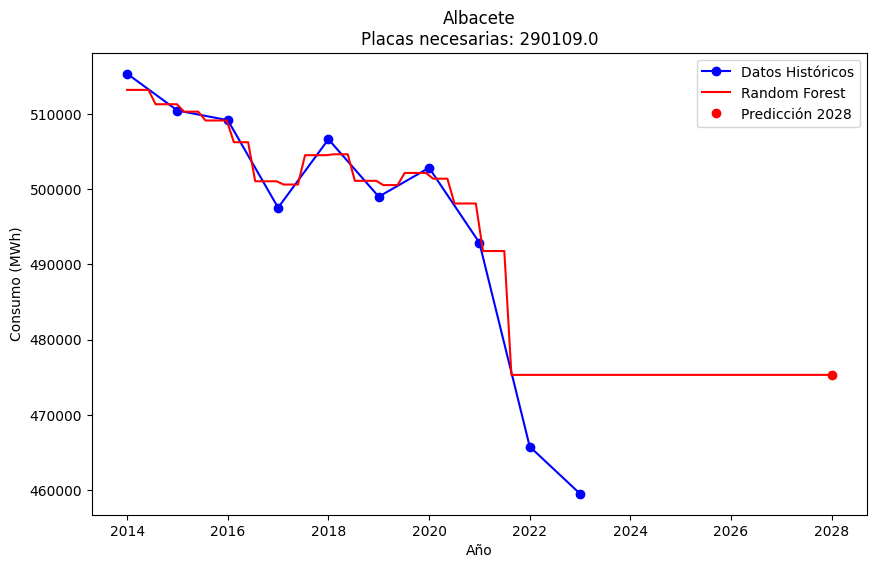

Albacete - MSE: 59142059.45, R2: 0.68


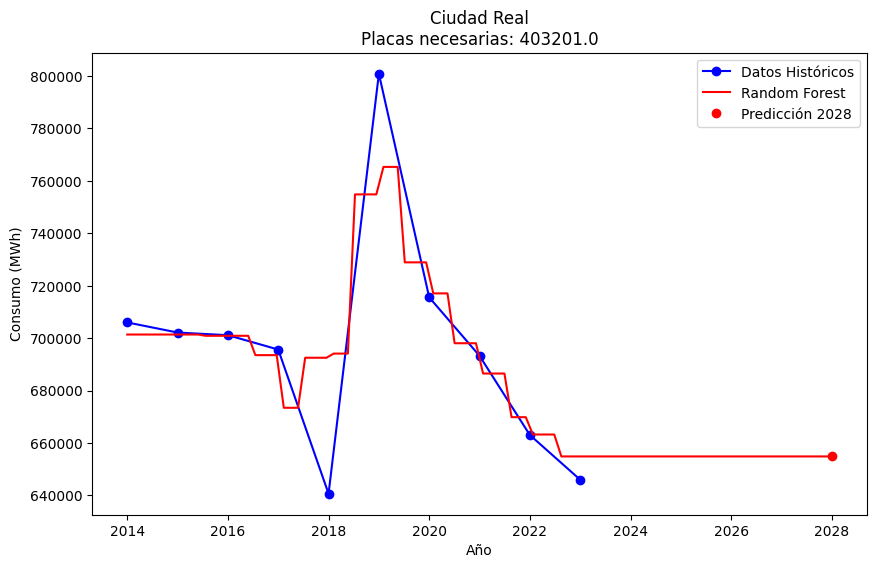

Ciudad Real - MSE: 12912099.71, R2: 0.52


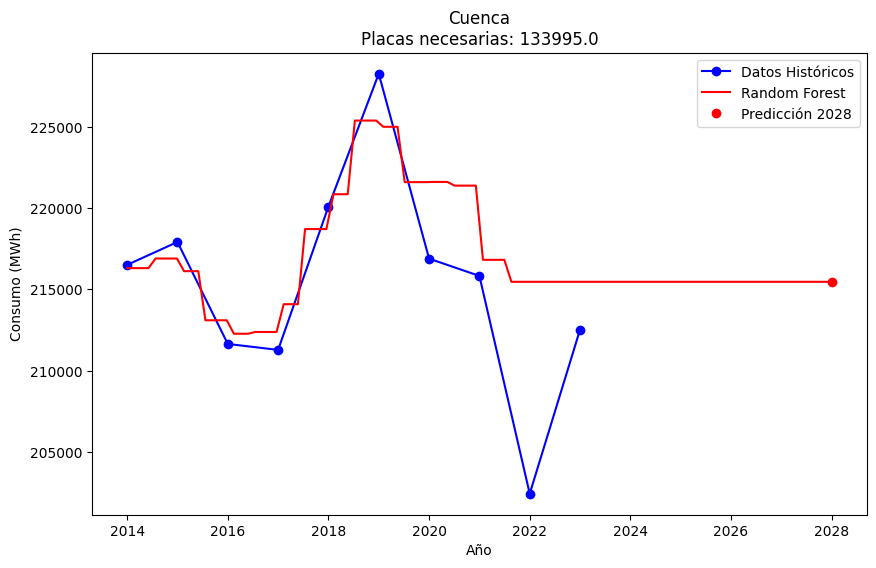

Cuenca - MSE: 100148372.22, R2: -1.24


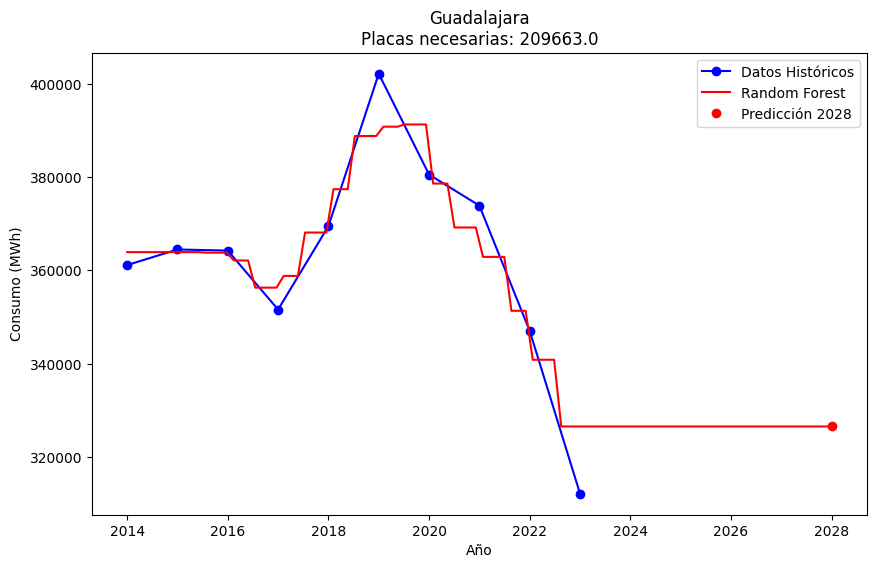

Guadalajara - MSE: 61635521.03, R2: 0.35


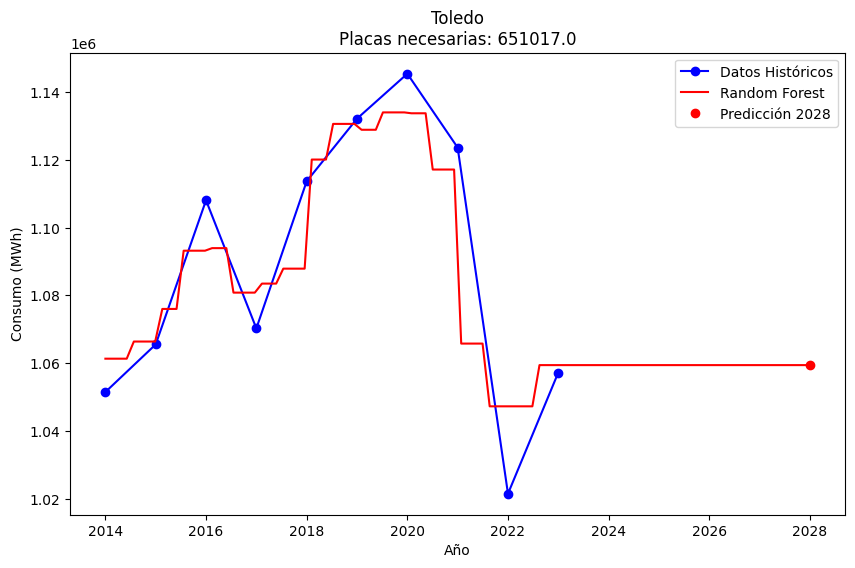

Toledo - MSE: 352443881.41, R2: -13.27


In [83]:
for provincia in data_card_5_df.index:
    X = np.array(consumo_df.columns.astype(int)).reshape(-1, 1)
    y = consumo_df.loc[provincia].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    modelo = RandomForestRegressor()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    prediccion_2028 = modelo.predict([[2028]])[0]
    potencia_placa = data_card_5_df.loc[provincia, 'Potencia MWh']
    placas = np.ceil(prediccion_2028 / potencia_placa)
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(X, y, 'bo-', label='Datos Históricos')
    X_fit = np.linspace(X.min(), 2028, 100).reshape(-1, 1)
    y_fit = modelo.predict(X_fit)
    plt.plot(X_fit, y_fit, 'r-', label='Random Forest')
    plt.plot(2028, prediccion_2028, 'ro', label='Predicción 2028')
    
    plt.title(f'{provincia}\nPlacas necesarias: {placas}')
    plt.xlabel('Año')
    plt.ylabel('Consumo (MWh)')
    plt.legend()
    plt.show()
    
    print(f"{provincia} - MSE: {mse:.2f}, R2: {r2:.2f}")